# Compare Task Overhead
Compare the difference sources of task overhead for our runs.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np
import json

Configuration

In [2]:
runs = {
    'Baseline': Path('./prod-runs/baseline_retrain-8/'),
    'Parsl+Redis': Path('./prod-runs/parsl_retrain-8/'),
    'FuncX+Globus': Path('./prod-runs/funcx_retrain-8/'),
}

## Load in Overhead Dataframes
We stored the results of each dataframe

In [3]:
results = {}
for k, path in runs.items():
    # Get the duplicates
    with open(path / 'duplicates.json') as fp:
        dupes = json.load(fp)
    
    # Compute the mean RMSD for each run
    results[k] = pd.concat([
        pd.read_csv(Path(p) / 'processed-results' / 'overheads.csv') for p in dupes
    ])

## Get the Distribution of Times
Make sure there are not significant outliers

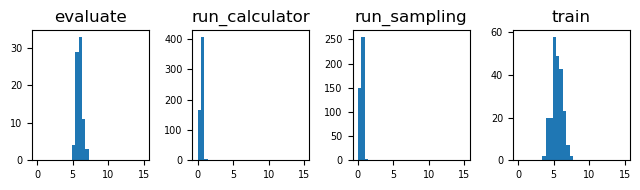

In [4]:
fig, axs = plt.subplots(1, 4, figsize=(6.5, 2.))

for (gid, group), ax in zip(results['FuncX+Globus'].groupby('method'), axs):
    ax.hist(group['overhead_total'], bins=np.linspace(0, 15, 32))
    ax.set_title(gid)
    
fig.tight_layout()

## Make a Box Plot
Plot the overhead for each type on task for each example

Baseline [0.9290439775213599, 0.3640177245251836, 0.8066235029837117, 0.0175610985606908]
Parsl+Redis [0.4774112207177268, 0.22940619277014146, 0.11483979283443621, 0.09492811342642679]
Parsl+Redis [0.4333351633580598, 0.2021528971969587, 0.18049819189676444, 0.1454969100064625]
FuncX+Globus [5.571819502225452, 5.914407295423503, 0.5816372614110401, 0.6107160277376806]
FuncX+Globus [5.053806318325956, 5.219687879746553, 0.16878908898432715, 0.146619713019801]


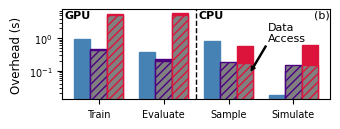

In [10]:
fig, ax = plt.subplots(figsize=(3.5, 1.4))

width = 0.25
colors = {
    'Baseline': 'steelblue',
    'FuncX+Globus': 'crimson',
    'Parsl+Redis': 'indigo'
}

methods = ['train', 'evaluate', 'run_sampling', 'run_calculator']
for i, (name, overheads) in enumerate(results.items()):
    # Make a bar plot where we show the 
    data = [overheads.query(f'method=="{method}"')['overhead_total'].median() for method in methods]
    pos = np.arange(4) - len(results) * width / 2 + i * width
    ax.bar(pos, data, color=colors[name], edgecolor=colors[name], width=width, align='edge', label=name)
    print(name, data)
    
    if "+" in name:
        overheads['time_resolving'] = overheads['time_input_resolution'] + overheads['time_output_resolution'] + overheads['overhead_serialization']
        data = [overheads.query(f'method=="{method}"')['time_resolving'].median()
                for method in methods]
        ax.bar(pos, data, color='gray', edgecolor=colors[name], width=width, align='edge', hatch='////')
        print(name, data)

# Make a verical bar denoting which are remote and which are local
ax.set_yscale('log')
ax.set_ylabel('Overhead (s)')
ax.set_ylim(ax.get_ylim())
ax.plot([1.5]*2, ax.get_ylim(), 'k--', lw=1)

# Annotate what the candy-cane parts mean
ax.annotate('Data\nAccess', xy=(2.35, 0.1), xytext=(2.6, 0.8), ha='left', fontsize=8,
            arrowprops={"width": 0.75, "color": "k", "headwidth": 3, "headlength": 3})

bbox_kwargs = None # {'facecolor': 'w', 'alpha': 0.5, "boxstyle": "round, pad=0.4"}
ax.text(0.01, 0.9, 'GPU', ha='left', transform=ax.transAxes, fontweight='bold', fontsize=8, bbox=bbox_kwargs)
ax.text(0.51, 0.9, 'CPU', ha='left', transform=ax.transAxes, fontsize=8, fontweight='bold', bbox=bbox_kwargs)
ax.text(1, 1, '(b)', ha='right', va='top', transform=ax.transAxes, fontsize=8)


#fig.legend(ncol=3, fontsize=8, loc='upper center')
    
ax.set_xticks([])
ax.set_xticks(np.arange(4))
ax.set_xticklabels(['Train', 'Evaluate', 'Sample', 'Simulate'])

fig.tight_layout()
fig.savefig('figures/overhead-comparison.png', dpi=320)
fig.savefig('figures/overhead-comparison.pdf')

Display the breakdown of latency for the training tasks of Globus

In [6]:
results['FuncX+Globus'].query('method=="train"').describe()

,time_created,time_result_sent,time_running,time_input_resolution,time_output_resolution,overhead_total,overhead_sending,overhead_serialization,overhead_reporting,time_resolving
count,2.640000e+02,2.640000e+02,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000
mean,1.675833e+09,1.675833e+09,266.138151,2.229728,0.669153,9.596669,6.833861,2.424960,2.760271,5.323841
std,2.328192e+04,2.328037e+04,7.940118,0.638524,0.997432,9.862056,9.910347,0.501353,0.529905,1.400283
min,1.675802e+09,1.675802e+09,248.799223,0.151477,0.200308,3.771087,1.697435,1.752809,1.893409,2.219834
25%,1.675814e+09,1.675814e+09,259.989572,1.816610,0.251258,5.099987,2.277905,1.869492,2.234403,4.562435
50%,1.675824e+09,1.675824e+09,265.791258,2.330416,0.286479,5.571820,2.891089,2.691080,2.893768,5.053806
75%,1.675860e+09,1.675861e+09,272.162197,2.711762,0.329337,6.406448,3.232577,2.790366,3.188574,5.854730
max,1.675871e+09,1.675871e+09,283.027727,3.634134,4.182287,35.051933,31.749455,3.669856,4.225296,9.945198
